0.....1.....2.....3.....4.....5.....6.....7.....8.....9.....======= Marker for calculating final statistics ========

================  General time frames for .... Drive Distance ============
11.639999999999999 12.76

                              totDriveDistance
algoName                                      
get_sorted_Distance                       12.6
get_sorted_DriveTime                      12.6
get_sorted_TravelTime                     12.6
get_sorted_Time                           11.8
get_sorted_passangerXY_reqXY              11.8

================  General time frames for ....tot_driveTime_PercIndivTime ============

                              tot_driveTime_PercIndivTime
algoName                                                 
get_sorted_Distance                              0.509804
get_sorted_DriveTime                             0.509804
get_sorted_TravelTime                            0.509804
get_sorted_Time                                  0.222222
get_sorted_pass

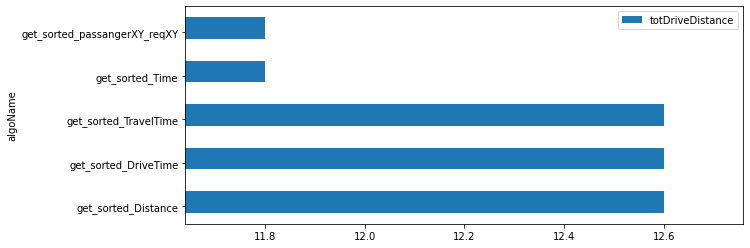

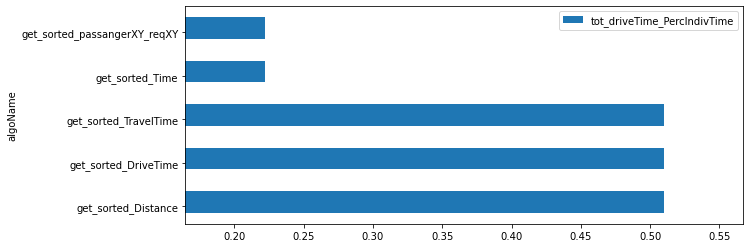

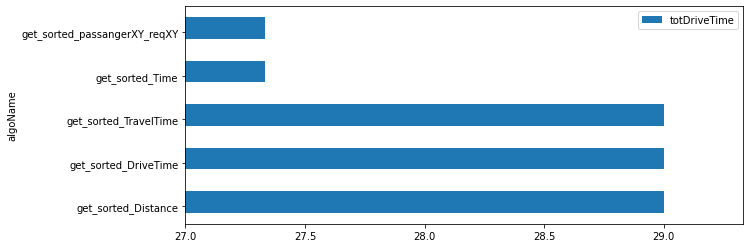

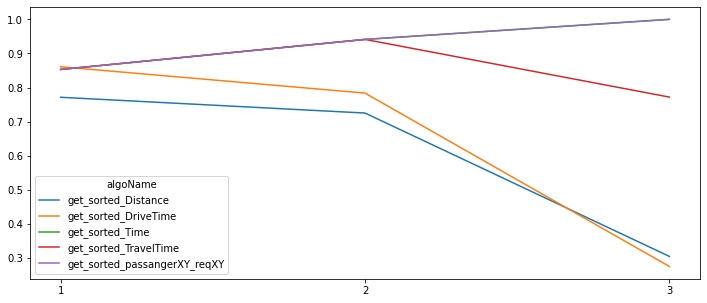

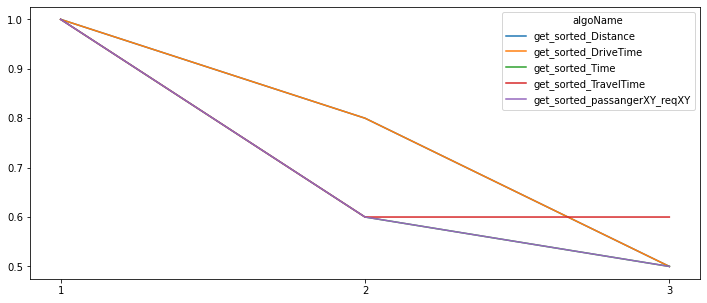

In [1]:
# === import modules

# --- set up for importing from sub folder, modules
#      note, ipynb and .py will not crash if file is missing
#           including both allows guarnateed transition from development to deployment
import os
import sys
programPath = os.path.dirname(os.path.abspath("tempTest.ipynb"))
sys.path.append(programPath + "\\modules")
programPath = os.path.dirname(os.path.abspath("tempTest.py"))
sys.path.append(programPath + "\\modules")

# --- For complex data structures
from copy import deepcopy

# --- Import core modules used in program
from Mapper import Mapper
from Ride_Requests import Ride_Requests
from Algorithms import Algorithms
from Route import Route
from Statistics import Statistics

# ========== set default values used in 
PICK_UP_WINDOW = 10
MIN_SCHEDULE_WINDOW = -45
MAX_SCHEDULE_WINDOW = 45
MAX_RIDE_TIME = 45

# ========== initialization
# --- Mapper requires program path to work in other directories
mapper = Mapper(programPath)
statistics = Statistics(mapper)

epochSize = 10
groupSize = 3
displayRouteCnt = 3

ride_requests = Ride_Requests(epochSize, groupSize, mapper)

algorithms = Algorithms(mapper)
algoDict = algorithms.get_algorithms()

    
def add_valid_request_to_route(route, request, options):
    # ---------- Loop to attempt to add requst based on options

    for option in options:
        # test changes on a copy of the route
        tempRoute, weight_PU, weight_DO = tempRouteTestingAddingStops(route, request, option)

        # note, behindStops is for future testing on route changes and force additions
        testRouteValid = tempRoute.testRouteValid()
        totTest = testRouteValid["deadTime"] + testRouteValid["behindStops"] 

        # new route with requested added for option is good
        #    return tempRoute  
        if (testRouteValid["deadTime"] <= 2) and (weight_DO >= 0) and (weight_PU >= 0):
            return tempRoute
        
        return route

# Adds request based on option.
#    returns tempRoute with stop_DO and stop_PU weights denoting 
#       how badly ride fits.  The routine decides if acceptable
#       Note, this weighted return is for future use.
def tempRouteTestingAddingStops(route, request, option):
    pnt_DO = option[2]
    time_DO = option[3]
    address_DO = request[1]
    pnt_PU = option[0]
    time_PU = option[1]
    address_PU = request[0]

    # Create drop off and pick op stop to add.
    stop_DO = [ID, time_DO, time_DO, time_DO + MAX_RIDE_TIME, address_DO]
    stop_PU = [ID, time_PU, time_PU, time_PU + PICK_UP_WINDOW, address_PU]
    
    # create copy so original is untouched until evaluated
    tempRoute = deepcopy(route)
    
    # add stop based on option pointer.
    #    note, Drop off comes first as it changes the indexes
    weight_DO = tempRoute.addStop(stop_DO, pnt_DO)
    weight_PU = tempRoute.addStop(stop_PU, pnt_PU)
    
    return tempRoute, weight_PU, weight_DO
        

if __name__ == "__main__":
    
    # ------ inline Main ride_requests TESTING -----  Epock Loop
    #    Process each group of requests, based on groupSize
    #       The final route is submitted to Statistics via addRoute
    for epoch in range(epochSize):
        print(epoch, end="")
        # Gets next group, unless end, then done with loop
        requestGroup = ride_requests.getNextRequestGroup()
        
        # For each algorithm being tested. ----------- Algorithms Loop
        algorithmNames = algoDict.keys()
        for aName in list(algoDict.keys()):
            #print("===== algorithm being used: ", aName)
            print(".", end="")

            # main route.  
            #     if new route is valid, replace with new route
            #     mapper, name of algorithm and where in epoch
            route = Route(mapper, aName, epoch)
            #route = loop_through_request_list_in_group(requestGroup, route, aName)
            
            if False:
                print("??? main 110 Requests being added")
                for r in requestGroup:
                    print("   ", r)
            
            # Loop through requests in requestGroup ----- Requests Loop
            for ID in range(groupSize):

                request = requestGroup[ID]
                requestTime = request[2]

                stops = route.get_stops()
                options = algoDict[aName](stops, request)

                route = add_valid_request_to_route(route, request, options)
                
            # displayRouteCnt = 3

            statistics.add_route(aName, epoch, requestGroup, route.get_stops())

            # ------ end algorithm by name loop
            
        # ------ end epoch testing loop
    
    statistics.displayStatistics() # which goes through calculate
                
    
    
    print("--- DONE -----")
    
    

In [2]:
import pandas as pd
df_rawStats = pd.DataFrame(statistics.stats, columns=statistics.columns)
print()
if False:
    print(df_rawStats[statistics.columns[:4]].head(30))
    print()
    print(df_rawStats[statistics.columns[4:]].head(30))
    #df.groupby(['Animal']).mean()

# this returns general averages.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! EXCEPT -> not apples to apples.. valid 0,1,3,4
# maybe group by with count

df1 = df_rawStats.groupby(by="algoName").mean()
# df.groupby(["item", "color"])["id"].transform("count")

# ************************* Works ************************** !!!!! NOT, doesn't work !!!!!!


# --------  sorte out by like iValid rides
#           To compare algorithms, each epoch must have same valid rides



#print(df1["iValid"].explode())#.groupby(level=0).mean())
#df1.groupby(by="algoName").mean()
#print(df_rawStats)




=================== ride Valid ==============

                                1    2    3
algoName                                   
get_sorted_Distance           1.0  0.8  0.5
get_sorted_DriveTime          1.0  0.8  0.5
get_sorted_Time               1.0  0.6  0.5
get_sorted_TravelTime         1.0  0.6  0.6
get_sorted_passangerXY_reqXY  1.0  0.6  0.5


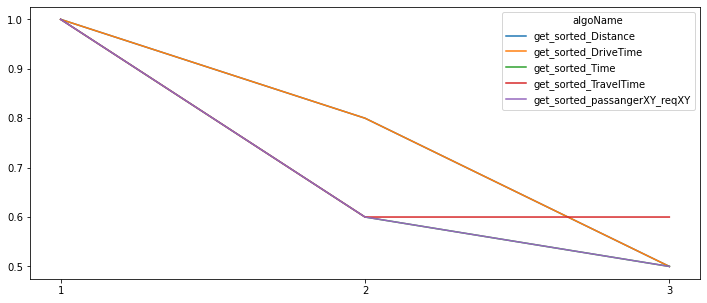

In [3]:
# this works for getting averages based on each rider
if True:
    print("=================== ride Valid ==============")
    df_iValid = pd.DataFrame(df_rawStats["iValid"].values.tolist())
    df_iValid['algoName'] = df_rawStats['algoName']
    print()
    dfMean = df_iValid.groupby('algoName').mean()
    newColumns = [i for i in range(1, len(dfMean.columns) + 1)]
    dfMean.columns = newColumns
    print(dfMean)

    dfMean.T.plot(figsize=(12,5), xticks=newColumns)


================  General time frames for ....total drive time ============

                              totDriveTime
algoName                                  
get_sorted_Distance              29.000000
get_sorted_DriveTime             29.000000
get_sorted_TravelTime            29.000000
get_sorted_Time                  27.333333
get_sorted_passangerXY_reqXY     27.333333


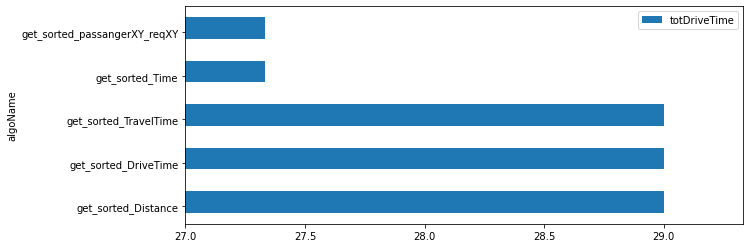

In [4]:
if True:
    df1 = df_rawStats
    print()
    print("================  General time frames for ....total drive time ============")
    
    # create a string column to compare valid rides with matching pattern
    df1['iValid2'] = [''.join(map(str, l)) for l in df_rawStats['iValid']]

    # create a count column, which, for each epoch, needs to be the max.  None max are removed.
    df1['count'] = df1.groupby(["epoch", "iValid2"])["iValid2"].transform("count")
    maxVal = df1['count'].max()
    df1 = df1[df1['count'] == maxVal]
    
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # calculate down to percentage... here... then get the means...
    #     for instance, drive distance, minimum and maximum is now 0 to 1 of all in the group!!!!!!

    # Get the means for each algorithm for total drvie time and total distance traveled by vehicle
    df1_mean = df1.groupby(by="algoName").mean()[["totDriveTime", "totDriveDistance"]]
    
    df1_mean = df1_mean.sort_values('totDriveTime', ascending=False)
    
    # calculate x from what to what for best perspective.  This is done as 1/5 of spread
    minTotDriveTime = df1_mean['totDriveTime'].min()
    maxTotDriveTime = df1_mean['totDriveTime'].max()
    margin = (maxTotDriveTime - minTotDriveTime) / 5
    xMin = 0
    if minTotDriveTime > margin:
        xMin = minTotDriveTime - margin
    
    print()
    print(df1_mean[["totDriveTime"]])
    df1_mean[['totDriveTime']].plot.barh(figsize=(10, 4), position=0.3, xlim=(xMin, maxTotDriveTime + margin))
    
    
    #tot_driveTime_PercIndivTime


================  General time frames for ....tot_driveTime_PercIndivTime ============

                              tot_driveTime_PercIndivTime
algoName                                                 
get_sorted_Distance                              0.509804
get_sorted_DriveTime                             0.509804
get_sorted_TravelTime                            0.509804
get_sorted_Time                                  0.222222
get_sorted_passangerXY_reqXY                     0.222222


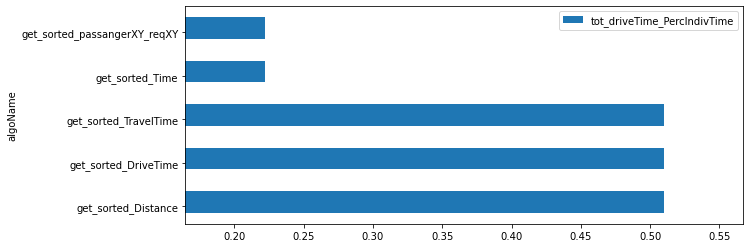

In [5]:
if True:
    df1 = df_rawStats
    print()
    print("================  General time frames for ....tot_driveTime_PercIndivTime ============")
    
    # create a string column to compare valid rides with matching pattern
    df1['iValid2'] = [''.join(map(str, l)) for l in df_rawStats['iValid']]

    # create a count column, which, for each epoch, needs to be the max.  None max are removed.
    df1['count'] = df1.groupby(["epoch", "iValid2"])["iValid2"].transform("count")
    maxVal = df1['count'].max()
    df1 = df1[df1['count'] == maxVal]
    
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # calculate down to percentage... here... then get the means...
    #     for instance, drive distance, minimum and maximum is now 0 to 1 of all in the group!!!!!!

    # Get the means for each algorithm for total drvie time and total distance traveled by vehicle
    df1_mean = df1.groupby(by="algoName").mean()[["tot_driveTime_PercIndivTime"]]
    
    df1_mean = df1_mean.sort_values('tot_driveTime_PercIndivTime', ascending=False)
    
    # calculate x from what to what for best perspective.  This is done as 1/5 of spread
    minTotDriveTime = df1_mean['tot_driveTime_PercIndivTime'].min()
    maxTotDriveTime = df1_mean['tot_driveTime_PercIndivTime'].max()
    margin = (maxTotDriveTime - minTotDriveTime) / 5
    xMin = 0
    if minTotDriveTime > margin:
        xMin = minTotDriveTime - margin
    
    print()
    print(df1_mean[["tot_driveTime_PercIndivTime"]])
    df1_mean[['tot_driveTime_PercIndivTime']].plot.barh(figsize=(10, 4), position=0.3, xlim=(xMin, maxTotDriveTime + margin))
    
    
    #tot_driveTime_PercIndivTime


================  General time frames for .... Drive Distance ============
11.639999999999999 12.76

                              totDriveDistance
algoName                                      
get_sorted_Distance                       12.6
get_sorted_DriveTime                      12.6
get_sorted_TravelTime                     12.6
get_sorted_Time                           11.8
get_sorted_passangerXY_reqXY              11.8


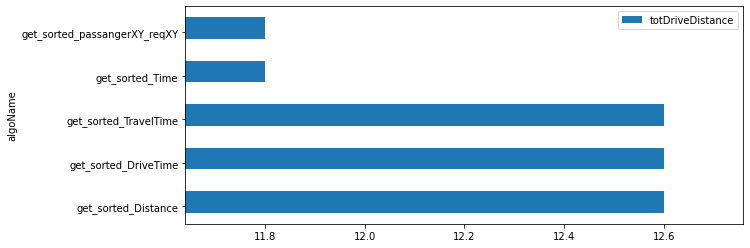

In [6]:
if True:
    df1 = df_rawStats
    print()
    print("================  General time frames for .... Drive Distance ============")
    
    # create a string column to compare valid rides with matching pattern
    df1['iValid2'] = [''.join(map(str, l)) for l in df_rawStats['iValid']]

    # create a count column, which, for each epoch, needs to be the max.  None max are removed.
    df1['count'] = df1.groupby(["epoch", "iValid2"])["iValid2"].transform("count")
    maxVal = df1['count'].max()
    df1 = df1[df1['count'] == maxVal]
    
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # calculate down to percentage... here... then get the means...
    #     for instance, drive distance, minimum and maximum is now 0 to 1 of all in the group!!!!!!
    df1_mean = df1.groupby(by="algoName").mean()[["totDriveDistance"]]
    # ----------------------------------------------------
     # calculate x from what to what for best perspective.  This is done as 1/5 of spread
    minTotDriveDistance = df1_mean['totDriveDistance'].min()
    maxTotDriveDistance = df1_mean['totDriveDistance'].max()
    margin = (maxTotDriveDistance - minTotDriveDistance) / 5
    xMin = 0
    if minTotDriveDistance > margin:
        xMin = minTotDriveDistance - margin
    xMax = maxTotDriveDistance + margin
    print(xMin, xMax)
        
    
    df1_mean = df1_mean.sort_values("totDriveDistance", ascending=False)
    
    print()
    print(df1_mean[["totDriveDistance"]])
    df1_mean[["totDriveDistance"]].plot.barh(figsize=(10, 4), position=0.3, xlim=(xMin, xMax))
    
    
    #tot_driveTime_PercIndivTime

=================== User ride time as a percentage ==============
           0         1         2                      algoName
0   0.866667  0.382353  0.480000           get_sorted_Distance
1   1.000000  0.406250       NaN          get_sorted_DriveTime
2   1.000000  1.000000       NaN               get_sorted_Time
3   1.000000  1.000000       NaN         get_sorted_TravelTime
4   1.000000  1.000000       NaN  get_sorted_passangerXY_reqXY
5   1.000000  1.000000  0.153846           get_sorted_Distance
6   1.000000  1.000000  0.153846          get_sorted_DriveTime
7   1.000000  1.000000  1.000000               get_sorted_Time
8   1.000000  1.000000  0.153846         get_sorted_TravelTime
9   1.000000  1.000000  1.000000  get_sorted_passangerXY_reqXY
10  1.000000       NaN       NaN           get_sorted_Distance
11  1.000000       NaN       NaN          get_sorted_DriveTime
12  1.000000       NaN       NaN               get_sorted_Time
13  1.000000       NaN       NaN         get_sorted_

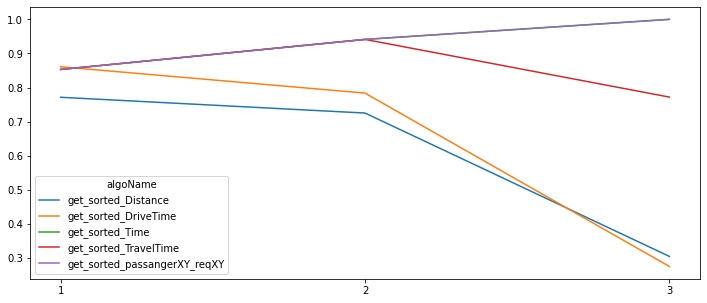

In [7]:
if True:
    df1 = df_rawStats
    print("=================== User ride time as a percentage ==============")
    df1 = pd.DataFrame(df_rawStats["indivPerc_rideTime"].values.tolist())
    df1['algoName'] = df_rawStats['algoName']
    print(df1.head(40))
    dfMean = df1.groupby('algoName').mean()
    print()
    print("dfMean")
    newColumns = [i for i in range(1, len(dfMean.columns)+1)]
    dfMean.columns = newColumns
    print(dfMean.head())
    dfMean.T.plot(figsize=(12,5), xticks=newColumns)
    